<a href="https://colab.research.google.com/github/darshlukkad/CRISP-DM_SEMMA_KDD/blob/main/KDD_Students_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📙 KDD: Students Performance (Regression)
We follow **KDD**: Selection → Cleaning/Preprocessing → Transformation → Data Mining → Interpretation/Evaluation  
**Dataset**: `spscientist/students-performance-in-exams` (Kaggle)

# 🚀 Step 1: One-time Kaggle setup (super easy)
1. Create a free Kaggle account (https://www.kaggle.com/).
2. Go to your Kaggle **Account** → scroll to **API** → click **Create New API Token**.
   - This downloads a file named **`kaggle.json`** to your computer.
3. In Colab, run the next cell. It will ask you to **upload `kaggle.json`**.

In [1]:
# Install and set up Kaggle API
!pip -q install kaggle

import os, zipfile, glob, shutil, json, sys
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

# Put kaggle.json in the right place
kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

if not (kaggle_dir / "kaggle.json").exists():
    try:
        from google.colab import files  # will work in Colab
        print("👉 Please upload your kaggle.json (you get it from Kaggle > Account > Create New API Token).")
        uploaded = files.upload()
        assert "kaggle.json" in uploaded, "You must upload a file named kaggle.json"
        with open(kaggle_dir / "kaggle.json", "wb") as f:
            f.write(uploaded["kaggle.json"])
        os.chmod(kaggle_dir / "kaggle.json", 0o600)
        print("✅ Installed kaggle.json")
    except Exception as e:
        print("If you're not in Colab, manually place kaggle.json in", kaggle_dir)
        raise e
else:
    print("✅ kaggle.json already present")

👉 Please upload your kaggle.json (you get it from Kaggle > Account > Create New API Token).


Saving kaggle.json to kaggle.json
✅ Installed kaggle.json


# 📥 Step 2: Download the dataset automatically
We will use the Kaggle API to download the dataset into the local `data/` folder.
If (rarely) Kaggle blocks the download, the next cells will let you **manually upload** the CSV instead.

In [2]:
# Download the Kaggle dataset
KAGGLE_DATASET = "spscientist/students-performance-in-exams"
print("⏬ Downloading:", KAGGLE_DATASET)
!kaggle datasets download -d $KAGGLE_DATASET -p $DATA_DIR --force

# Unzip any archives into data/
import zipfile, io
for z in DATA_DIR.glob("*.zip"):
    with zipfile.ZipFile(z, "r") as zip_ref:
        zip_ref.extractall(DATA_DIR)
    z.unlink()

print("📂 Contents of data/:", [p.name for p in DATA_DIR.iterdir()])

⏬ Downloading: spscientist/students-performance-in-exams
Dataset URL: https://www.kaggle.com/datasets/spscientist/students-performance-in-exams
License(s): unknown
  0% 0.00/8.70k [00:00<?, ?B/s]
100% 8.70k/8.70k [00:00<00:00, 33.8MB/s]
📂 Contents of data/: ['StudentsPerformance.csv']


# 🆘 If needed: Manual upload fallback
If you don't see a CSV in `data/`, run the next cell and upload the CSV from Kaggle manually.
(Go to the dataset page on Kaggle and click **Download** to get the zip; extract the CSV and upload here.)

In [3]:
from pathlib import Path
csvs = list(Path("data").glob("*.csv"))
if not csvs:
    try:
        from google.colab import files
        print("No CSV detected in data/. Please upload the CSV file now.")
        uploaded = files.upload()
        # Save the first uploaded CSV into data/
        for k, v in uploaded.items():
            if k.lower().endswith(".csv"):
                with open(Path("data")/k, "wb") as f:
                    f.write(v)
        print("✅ Uploaded CSV to data/.")
    except Exception as e:
        raise RuntimeError("Still no CSV found. Please upload a CSV to data/.") from e
else:
    print("✅ CSV already present:", [c.name for c in csvs])

✅ CSV already present: ['StudentsPerformance.csv']


# 🧰 Step 3: Imports and reproducibility

In [4]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import warnings, sys, os, re
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Load data and define problem
We’ll predict **`math score`** from demographic/context features and the other scores.

In [5]:
from pathlib import Path
import pandas as pd

candidates = list(Path("data").glob("*.csv"))
assert candidates, "No CSVs found; please ensure StudentsPerformance.csv is in data/."
csv_path = None
for p in candidates:
    if "StudentsPerformance" in p.name or "Students" in p.name:
        csv_path = p
        break
if csv_path is None:
    csv_path = candidates[0]

print("Using CSV:", csv_path)
df = pd.read_csv(csv_path)
print(df.head())
print(df.shape)
print(df.isna().sum())

Using CSV: data/StudentsPerformance.csv
   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  
(1000, 8)
gender                         0
race/ethnicity                 0
parental level of education    0
lunch     

## Cleaning / Preprocessing
- Handle missing values (if any)
- Split features/target

In [6]:
df2 = df.copy()

target = 'math score'
y = df2[target]
X = df2.drop(columns=[target])

print("Features:", X.columns.tolist())

Features: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'reading score', 'writing score']


## Transformation
- One-hot encode categoricals
- Scale numerics

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

print("Categorical:", cat_cols)
print("Numeric:", num_cols)

Categorical: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
Numeric: ['reading score', 'writing score']


## Data Mining (Modeling)
We’ll compare a **Linear Regression** baseline with a **Random Forest Regressor**.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

lin = Pipeline([('prep', preprocess), ('mdl', LinearRegression())])
rf = Pipeline([('prep', preprocess), ('mdl', RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE))])

lin.fit(X_train, y_train)
rf.fit(X_train, y_train)

def eval_reg(model, Xv, yv, name):
    pred = model.predict(Xv)
    print(f"\n=== {name} ===")
    print("R2:", r2_score(yv, pred))
    print("MAE:", mean_absolute_error(yv, pred))

eval_reg(lin, X_test, y_test, "LinearRegression (Test)")
eval_reg(rf, X_test, y_test, "RandomForest (Test)")


=== LinearRegression (Test) ===
R2: 0.8778243107659012
MAE: 4.337930600167407

=== RandomForest (Test) ===
R2: 0.8501942376979408
MAE: 4.733844880952382


## Interpretation / Evaluation
Show **feature importance** (from Random Forest) and discuss what matters.

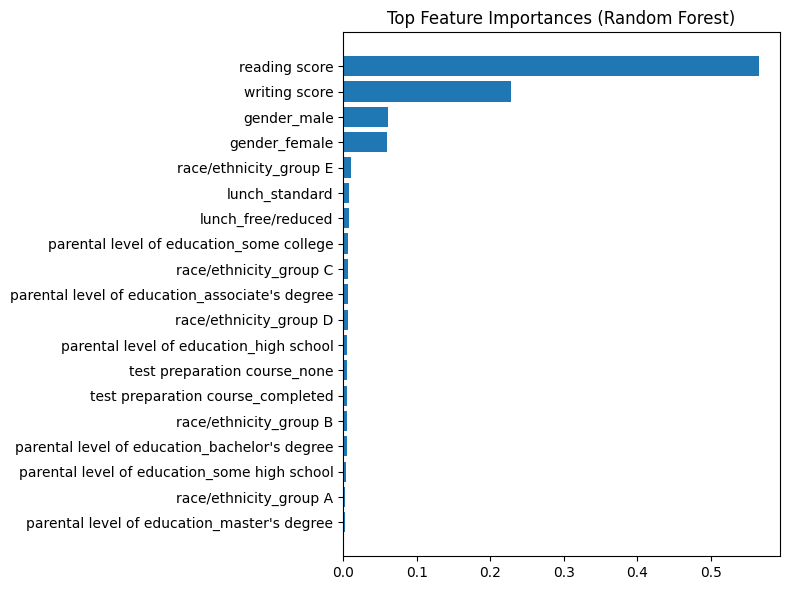

✅ KDD flow complete!


In [9]:
import numpy as np

best = rf  # usually stronger for non-linear patterns
# Retrieve feature names after preprocessing
ohe = best.named_steps['prep'].named_transformers_['cat']
num_cols = best.named_steps['prep'].transformers_[1][2]

cat_feature_names = list(ohe.get_feature_names_out())
feature_names = cat_feature_names + list(num_cols)

importances = best.named_steps['mdl'].feature_importances_
idx = np.argsort(importances)[-20:][::-1]  # top 20

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.barh([feature_names[i] for i in idx][::-1], importances[idx][::-1])
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

print("✅ KDD flow complete!")

---
### 🔍 (Optional) Ask an AI to critique your KDD pipeline
> *"Act as a world-renowned authority on KDD. Critique my **Selection, Cleaning, Transformation, Data Mining, and Interpretation** steps for completeness, reproducibility, and knowledge extraction quality. Provide prioritized improvements."*